# Geological model

Assemble the geological model from xyz data for each surface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import SmoothBivariateSpline, RectBivariateSpline

import conduction

In [2]:
directory = '/opt/ben/'
directory = '/opt/ben/Dropbox/GOTherm/ireland_model/crust_hires/'

These layers define the volume between each surface in the `layers_xy` folder.

Turns out these layers are defined on a grid...

In [3]:
nl = 18 # number of lithologies

layer = dict()
for i in xrange(0, nl):
    data = np.loadtxt(directory+'layers_xy/layer{}.xyz'.format(i))
    layer[i] = data

In [4]:
minX, maxX = (350000.0, 788000.0)
minY, maxY = (480000.0, 1000000.0)

# overwrite minZ/maxZ
minZ = -130e3
maxZ = 600.0

In [5]:
spl = dict()

for i in xrange(nl):
    data = layer[i]
    xl = data[:,0]
    yl = data[:,1]
    
    Xcoords = np.unique(xl)
    Ycoords = np.unique(yl)
    nx, ny = Xcoords.size, Ycoords.size
    
    zl = data[:,2].reshape(ny,nx)

    spl[i] = RectBivariateSpline(Ycoords, Xcoords, zl)

We will create 2D bivariate splines to interpolate the x,y coordinates with z property.

> We need to play with $s$ to get optimal smoothness

## Setup the hexahedral mesh

In [6]:
Nx, Ny, Nz = 51, 51, 204

mesh = conduction.ConductionND((minX, minY, minZ), (maxX, maxY, maxZ), (Nx, Ny, Nz))

coords = mesh.coords

Xcoords = np.unique(coords[:,0])
Ycoords = np.unique(coords[:,1])
Zcoords = np.unique(coords[:,2])

nx, ny, nz = Xcoords.size, Ycoords.size, Zcoords.size

## Fill the volume between each surface

A flood-fill algorithm, like the poisson-disc sampler, would do well with surfaces that curve back on themselves. Best case this is a $O(n)$ algorithm. Since we know that these surfaces are like pancakes, we can opt for an indexing-fill approach column-by-column. This should be $O(\log n)$ efficiency.

For geometries that curve in on themselves, another way to seal holes in the mesh is required. For now the spline is more than adequate.

In [7]:
xq, yq = np.meshgrid(Xcoords, Ycoords)
xq = xq.ravel()
yq = yq.ravel()

horizontal_slice = np.column_stack([xq, yq])

In [8]:
# create layer voxel
layer_voxel = np.zeros((nz, ny, nx), dtype=np.int8)
layer_mask = np.zeros(nx*ny*nz, dtype=bool)

# create KDTree
tree = cKDTree(coords)

In [9]:
def query_nearest(l):
    layer_mask.fill(0)
    
    zq = spl[l].ev(yq, xq)
    d, idx = tree.query(np.column_stack([xq, yq, zq]))
    layer_mask[idx] = True
    
    return np.where(layer_mask.reshape(nz,ny,nx))

layer_voxel.fill(-1)

for l in xrange(nl):
    i0, j0, k0 = query_nearest(l)

    for i in xrange(i0.size):
        layer_voxel[:i0[i], j0[i], k0[i]] = l+1

    print("mapped layer {}".format(l))

mapped layer 0
mapped layer 1
mapped layer 2
mapped layer 3
mapped layer 4
mapped layer 5
mapped layer 6
mapped layer 7
mapped layer 8
mapped layer 9
mapped layer 10
mapped layer 11
mapped layer 12
mapped layer 13
mapped layer 14
mapped layer 15
mapped layer 16
mapped layer 17


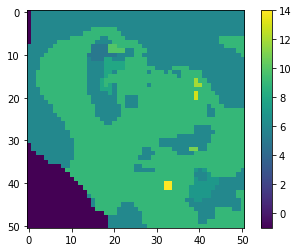

In [10]:
plt.imshow(layer_voxel[201])
plt.colorbar()

In [11]:
mesh.save_mesh_to_hdf5('new_crustal_lithologies.h5')
mesh.save_field_to_hdf5('new_crustal_lithologies.h5', lithology=layer_voxel.ravel())
conduction.tools.generateXdmf('new_crustal_lithologies.h5')

/home/bmather/.local/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Now map properties to these layers. Where these layers are not defined we have a default value assigned to them.

In [ ]:
k = np.ones_like(layer_voxel, dtype=np.float32)*3
H = np.zeros_like(layer_voxel, dtype=np.float32)

for i, l in enumerate(layer_number):
    name = layer_name[i]
    mask = layer_voxel == l
    ki = layer_attributes[i,2]
    Hi = layer_attributes[i,3]
    k[mask] = ki
    H[mask] = Hi
    print('{} {} \t k = {}, H = {}'.format(l, name, ki, Hi))
    
k = k.ravel()
H = H.ravel()

In [ ]:
# Update properties
mesh.update_properties(k, H)

# Boundary conditions
mesh.boundary_condition('maxZ', 298.0, flux=False)
mesh.boundary_condition('minZ', 1300., flux=False)

In [ ]:
sol = mesh.solve('bcgs')

In [ ]:
H5_file = 'geological_model.h5'

mesh.save_mesh_to_hdf5(H5_file)
mesh.save_field_to_hdf5(H5_file, ID=layer_voxel.ravel(), k=mesh.diffusivity, H=mesh.heat_sources, T=sol)
conduction.generateXdmf(H5_file)

Heat flow slice

In [ ]:
T0 = sol.reshape(nz,ny,nx)[-1,:,:]
T1 = sol.reshape(nz,ny,nx)[-2,:,:]

k0 = sol.reshape(nz,ny,nx)[-1,:,:]

HF = k0*(T1 - T0)/(Zcoords[-1] - Zcoords[-2])

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, xlim=[minX, maxX], ylim=[minY, maxY])
im1 = ax1.imshow(HF, origin='lower', extent=[minX, maxX, minY, maxY], aspect='equal')
fig.colorbar(im1)
plt.imshow(HF)
plt.savefig('HF.png')